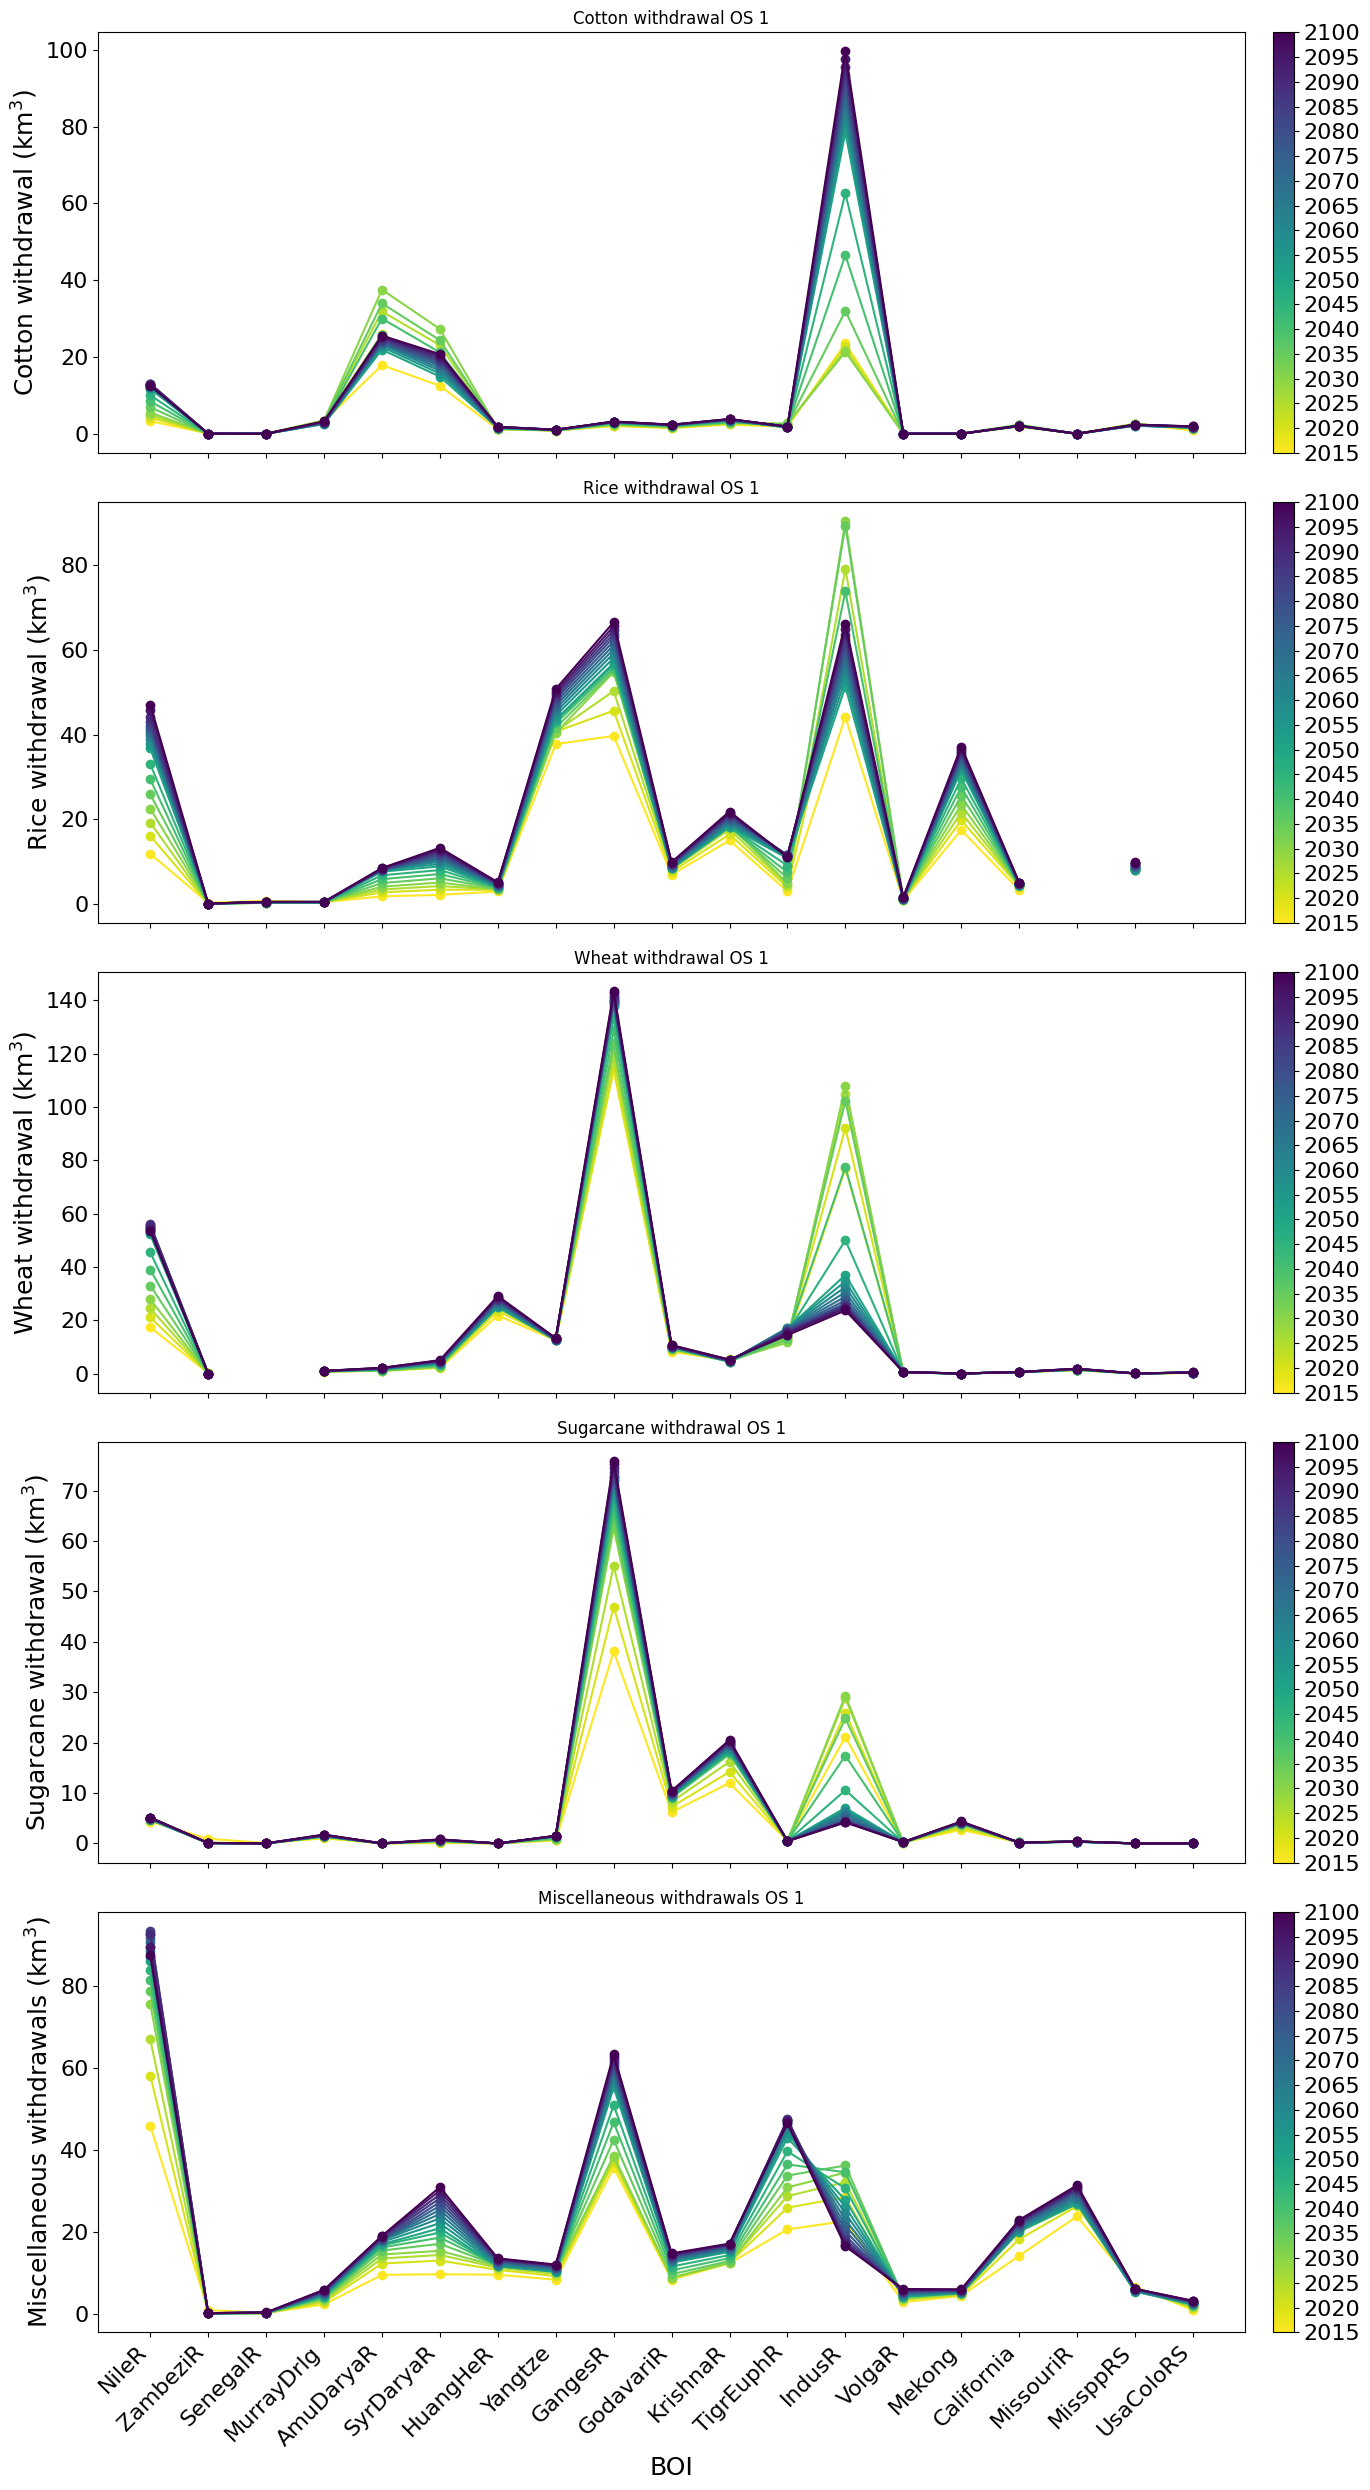

In [4]:
##Updated plot for OS5 60 indus outlying scenarios stacked vertically 
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


plt.rcParams['image.cmap'] = 'viridis_r'  # Use reversed viridis colormap
plt.rcParams['axes.labelsize'] = 18  # Set axes label size
plt.rcParams['xtick.labelsize'] = 16  # Set x-tick label size
plt.rcParams['ytick.labelsize'] = 16  # Set y-tick label size
plt.rcParams['figure.figsize'] = [20, 25]  # Set figure size
#plt.rcParams['colorbar.ticks'] = np.linspace(2015, 2100, 18)  # Set colorbar ticks for 18 discrete units


# Define the input directory with the merged .pkl files
input_directory = "TOE_BOI_Merged_Withdrawals_for_60_scenarios"  

columns_to_plot = ['FiberCrop_withdrawal', 'Rice_withdrawal', 'Wheat_withdrawal', 'SugarCrop_withdrawal', 'MiscAll_withdrawals']

# Load all dataframes and store them in a single list
all_dfs = []

# Traverse through the input directory and load each file
for root, _, files in os.walk(input_directory):
    for file_name in files:
        if file_name.endswith('.pkl'):
            file_path = os.path.join(root, file_name)
            df = pd.read_pickle(file_path)
            boi_name = '_'.join(file_name.split('_')[:4])
            df['BOI'] = boi_name  # Add BOI column to distinguish BOIs
            all_dfs.append(df)

# Dictionary to track missing columns for each BOI
missing_columns_info = {}

# Check if there are any dataframes to merge and plot
if all_dfs:
    # Concatenate all dataframes into a single dataframe
    merged_df = pd.concat(all_dfs, ignore_index=True)

    # Ensure all specified years are included and fill missing years with NaN
    years_to_include = list(range(2015, 2101, 5))
    for year in years_to_include:
        if year not in merged_df['year'].values:
            for boi in merged_df['BOI'].unique():
                missing_year_row = {col: np.nan for col in merged_df.columns}
                missing_year_row['year'] = year
                missing_year_row['BOI'] = boi
                merged_df = merged_df.append(pd.DataFrame(missing_year_row, index=[0]), ignore_index=True)

    # Sort by BOI and year to ensure order
    merged_df = merged_df.sort_values(by=['BOI', 'year']).reset_index(drop=True)
    merged_df = merged_df.rename(columns={'FiberCrop_withdrawal': 'Cotton_withdrawal', 
                                          'SugarCrop_withdrawal': 'Sugarcane_withdrawal',
                                          'MiscAll_withdrawals': 'Miscellaneous_withdrawals'})

    # Update the list of columns to plot
    columns_to_plot = ['Cotton_withdrawal', 'Rice_withdrawal', 'Wheat_withdrawal', 'Sugarcane_withdrawal', 'Miscellaneous_withdrawals']


    # Process the 'Input' column
    merged_df['input'] = merged_df['input'].str.replace('water_td_irr_', '')
    merged_df['input'] = merged_df['input'].str.replace('_W', '')

    # Create a figure and axes for the plots
    fig, axs = plt.subplots(len(columns_to_plot), 1, figsize=(15, 25), sharex=True)
    cmap = plt.cm.viridis_r  # Reverse viridis colormap

    for idx, column in enumerate(columns_to_plot):
        ax = axs[idx]

        # Check which BOIs are missing the current column
        missing_boIs = []
        for boi in merged_df['BOI'].unique():
            if column not in merged_df[merged_df['BOI'] == boi].columns:
                missing_boIs.append(boi)

        # Print missing BOIs for the current column
        if missing_boIs:
            print(f"Skipping the following BOIs for {column} due to missing column: {', '.join(missing_boIs)}")

        # Filter out BOIs that do not have the required column
        valid_boI_df = merged_df[~merged_df['BOI'].isin(missing_boIs)]

        if valid_boI_df.empty:
            print(f"Skipping plot for {column} as no BOIs have this column.")
            continue

        years = valid_boI_df['year'].unique()
        colors = cmap(np.linspace(0, 1, len(years)))

        # Draw parallel coordinates plot
        for color, year in zip(colors, years):
            year_df = valid_boI_df[valid_boI_df['year'] == year]
            ax.plot(year_df['input'], year_df[column], marker='o', linestyle='-', label=year, color=color)

        # Formatting the plot
        ax.set_xticks(range(len(valid_boI_df['input'].unique())))
        ax.set_xticklabels(valid_boI_df['input'].unique(), rotation=45, ha='right')
        ax.set_ylabel(f"{column.replace('_', ' ')} (km$^3$)")
        ax.set_title(f'{column.replace("_", " ")} OS 1')

        # Create a colorbar for each subplot
        norm = plt.Normalize(years.min(), years.max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
        cbar.set_ticks(np.linspace(years.min(), years.max(), 18))

        if idx == len(columns_to_plot) - 1:
            ax.set_xlabel('BOI')

    plt.tight_layout()
    plt.savefig(os.path.join(input_directory, f"Time_dynamics_parallel_plots_all_BOIs_OS1.png"), dpi=300)
    #plt.close()
    plt.show()
else:
    print("No valid dataframes found.")
